# Layer Cake Example: Regularization Part 1

#### In this example we will see basic functionality of the `KirchMig.jl` package, including standard and least-squares Kirchhoff migration demigration.

### 0. Load modules

In [1]:
using Distributed
addprocs(Sys.CPU_THREADS)

import PyPlot; const plt = PyPlot
import DSP: conv
import Random: seed!, randperm
import Statistics: std

import KirchMig

### 1. Create reflection data

First step is to create a reflection data, which we will use to demonstrate Kirchhoff demigration. Later, we will use this data for migration.

In [2]:
dz, dx = 15, 15
x = 0:dx:1000; nx = length(x)
z = 0:dz:1000; nz = length(z)

rho = 1000ones(nz, nx)
rho[div(330,dx):end,:] .+= 1000
rho[div(670,dz):end,:] .-= 500

vel = 2000 .+ zero(rho)

imp = 1e-3rho.*vel;

refl = [zeros(nx)'
    (imp[2:end,:] .- imp[1:end-1,:])./(imp[2:end,:] .+ imp[1:end-1,:])]

refl[div(nz, 2)-1, div(nx, 2)] += 0.2
refl[div(nz, 2)+1, div(nx, 2)] += 0.2;

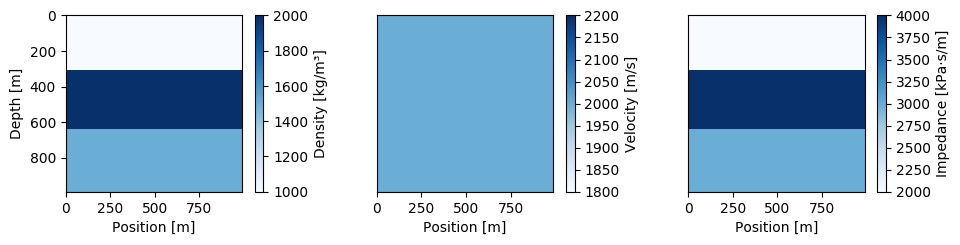

In [3]:
fig, ax = plt.subplots(1, 3, figsize=(10,2.5))

# Density
cax = ax[1][:imshow](rho, extent=[x[1], x[end], z[end], z[1]], aspect="equal", cmap="Blues", interpolation=nothing)
ax[1][:set](xlabel="Position [m]", ylabel="Depth [m]")
cbar = fig[:colorbar](cax, ax=ax[1])
cbar[:ax][:set](ylabel="Density [kg/m³]")

# Velocity
cax = ax[2][:imshow](vel, extent=[x[1], x[end], z[end], z[1]], aspect="equal", cmap="Blues", interpolation=nothing)
ax[2][:set](xlabel="Position [m]", yticks=[])
cbar = fig[:colorbar](cax, ax=ax[2])
cbar[:ax][:set](ylabel="Velocity [m/s]");

cax = ax[3][:imshow](imp, extent=[x[1], x[end], z[end], z[1]], aspect="equal", cmap="Blues", interpolation=nothing)
ax[3][:set](xlabel="Position [m]", yticks=[])
cbar = fig[:colorbar](cax, ax=ax[3])
cbar[:ax][:set](ylabel="Impedance [kPa·s/m]");
fig[:tight_layout]()

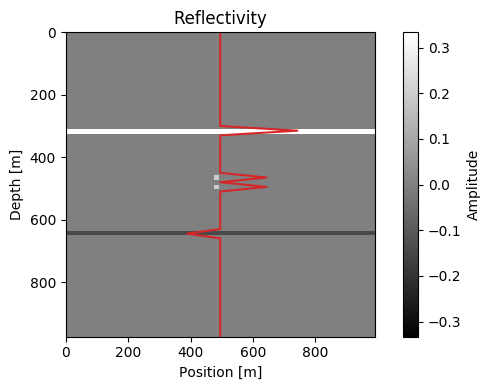

In [4]:
xran = x[end]-x[1]
mod = reshape(refl, nz, nx)
vmin, vmax = maximum(abs.(mod))*[-1,1]
fig, ax = plt.subplots(figsize=(6,4))
cax = ax[:imshow](mod, extent=[x[1], x[end], z[end], z[1]],
    vmin=vmin, vmax=vmax, aspect="equal", cmap="gray", interpolation=nothing)
cbar = fig[:colorbar](cax, ax=ax)
cbar[:ax][:set](ylabel="Amplitude");
ax[:plot](xran*mod[:,div(end,2)]./(4vmax) .+ xran./2, z, color="#d62728");
ax[:set](xlim=(x[1], x[end]), ylim=(z[end-1], z[1]), xlabel="Position [m]", ylabel="Depth [m]",
    title="Reflectivity")
fig[:tight_layout]()

### 2. Create traveltime tables

The Kirchhoff modeling (or, more acurately, demigration) and migration operators require source/receiver traveltime tables. That is, they require one to know traveltimes from each source/receiver to each model point. In the case of a constant velocity, this can be easily calculated with the this formula:

$$ trav(z, x; z_{S/R}, x_{S/R}) = \frac{\sqrt{(z-z_{S/R})^2 + (x-x_{S/R})^2)}}{v}$$

where $(z, x)$ are the coordinates of subsurface point, $(z_{S/R}, x_{S/R})$ are the coordinates of the source/receiver and $v$ is the velocity.

This calculated is implemented in `eikonal_const_vel`, whose first argument takes an `AbstractMatrix` whose first column contains $z$ coordinates of all sources (or receivers), $z_{S/R,1}, \ldots z_{S/R,n}$; the second column contains $x$ coordinates of these same sources $x_{S/R,1}, \ldots x_{S/R,n}$, and so on until all spatial dimensions are accounted for. Its second and third arguments take `AbstractVector`s representing, respecively, $z$ and $x$ subsurface locations. In 3D, the fourth argument are the subsurface $y$ locations. The last argument is the velocity.

Previously we used coinciding sources/receivers, this time we will use randomized sources.

In [5]:
nr = 46

rec_z = zeros(nr)
rec_x = range(x[1], stop=x[end], length=nr)

ns = 10
seed!(12)
src_z = zeros(ns)
src_x = sort(rec_x[randperm(nr)][1:ns])

trav_r = KirchMig.eikonal_const_vel([rec_z rec_x], z, x, vel[1]);
trav_s = KirchMig.eikonal_const_vel([src_z src_x], z, x, vel[1]);

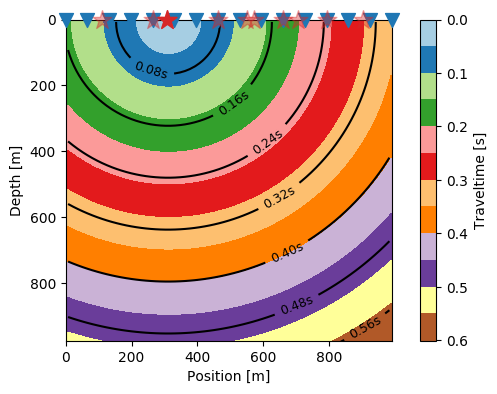

In [6]:
fig, ax = plt.subplots(figsize=(6,4))
cax = ax[:imshow](trav_s[:,:,div(ns,3)], extent=[x[1], x[end], z[end], z[1]], aspect="equal", cmap="Paired",
    interpolation="bilinear", vmin=0, vmax=maximum(trav_s[:,:,div(ns,3)]))
cbar = fig[:colorbar](cax, ax=ax)
cbar[:ax][:set](ylabel="Traveltime [s]")
cbar[:ax][:invert_yaxis]() 
ax[:scatter](rec_x[1:3:end], rec_z[1:3:end], color="#1f77b4", marker="v", s=100, clip_on=false, zorder=100)
ax[:scatter](src_x, src_z, color="#d62728", alpha=0.4, marker="*", s=200, clip_on=false, zorder=100)
ax[:scatter](src_x[div(ns,3)], src_z[div(ns,3)], color="#d62728", marker="*", s=200, clip_on=false, zorder=100)
con = ax[:contour](trav_s[:,:,div(ns,3)], extent=[x[1], x[end], z[end], z[1]], origin="upper", colors="k")
plt.clabel(con, fontsize=9, inline=1, fmt="%1.2fs");
ax[:set](xlabel="Position [m]", ylabel="Depth [m]", xlim=(x[1], x[end]), ylim=(z[end-1], z[1]))
fig[:tight_layout]()

### 3. Kirchhoff demigration (modeling)

`KirchMap` provides a simple to use interface around modeling and migration. The forward map performs modeling, and the adjoint performs migration. In simple terms, if `m` is the reflectivity model (in vector format) and `d` is the reflection response data, modeling is performed with

$$ Lm = d $$

and migration is performed with

$$ m_\text{mig} = L^\dagger d.$$

Both operations rely on two key pieces of information. The first is the time axis of the data. We will create a standard time axis of at most `2 s` sampling every `4 ms`. The second are the traveltime tables, which we have computed above.

Strictly speaking, the Kirchhoff operator does not contain the wavelet; thus to compute the full forward map $L$ we must first apply the Kirchhoff operator $G$ and then the convolution with the wavelet symbolized by operator $W$.

In [7]:
t = 0:0.008:1; nt = length(t)
G = KirchMig.KirchMap(t, trav_r, trav_s);

Once the operator is defined, Kirchhoff modeling (for delta sources) is carried out like a simple matrix-vector multiplication.

In [8]:
@time Gm = G*view(refl, :); # refl is 67×67 a array, view(refl, :) is a 4489-element vector

As per the theory, we also convolve the forward operator with the second time-derivative of the source wavelet:

In [9]:
ricker(t0, f) = @. (1 - 2pi^2 * f^2 * t0^2) * exp(-pi^2 * f^2 * t0^2)
rick_dtt = ricker(t .- t[div(nt,5)], 15);
@views rick_dtt[2:end-1] = (rick_dtt[1:end-2] - 2.0*rick_dtt[2:end-1] + rick_dtt[3:end])/(t[2] - t[1])^2;
rick_dtt /= maximum(abs.(rick_dtt));

W = KirchMig.ConvMap(rick_dtt, nr, ns, nt);

d = W*Gm;

Finally, we add some noise as well, to better assess regularization methods.

In [10]:
seed!(1)
n = randn(size(d))
d += n*std(d)/std(n);

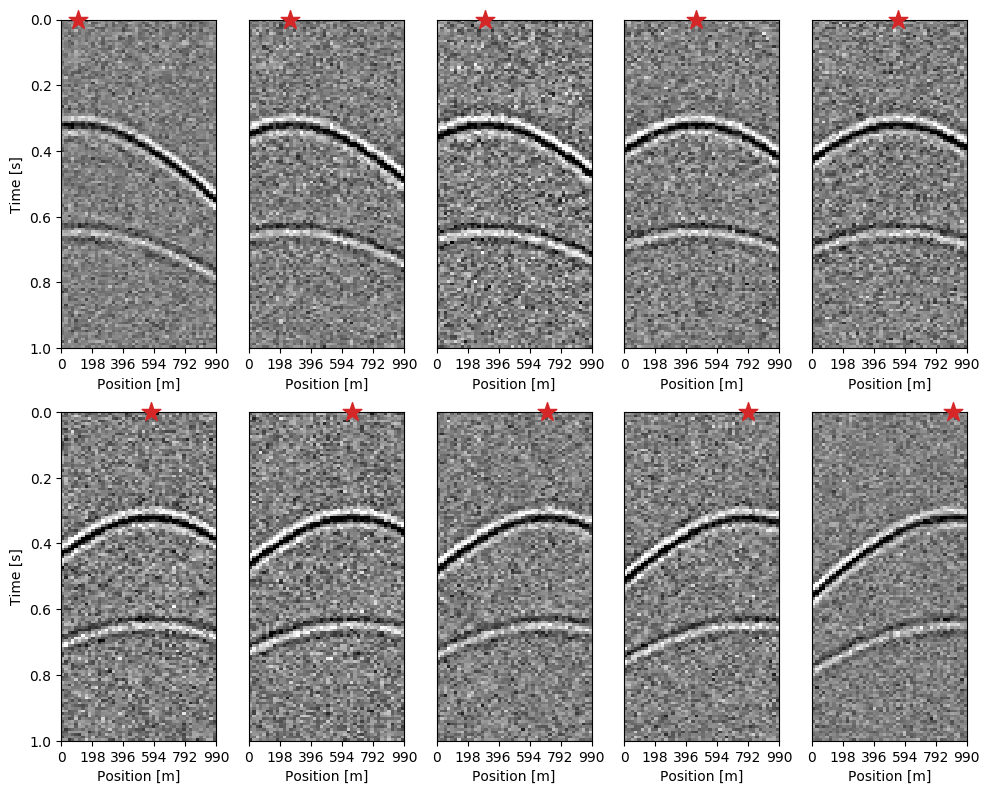

┌ Warning: The default `strides(a::AbstractArray)` implementation is deprecated for general arrays.
│ Specialize `strides(::LinearAlgebra.Adjoint)` if `LinearAlgebra.Adjoint` indeed uses a strided representation in memory.
│ Warning: inappropriately implementing this method for an array type that does not use strided
│ storage may lead to incorrect results or segfaults.
│   caller = stride at abstractarray.jl:350 [inlined]
└ @ Core ./abstractarray.jl:350
┌ Warning: The default `strides(a::AbstractArray)` implementation is deprecated for general arrays.
│ Specialize `strides(::LinearAlgebra.Adjoint)` if `LinearAlgebra.Adjoint` indeed uses a strided representation in memory.
│ Warning: inappropriately implementing this method for an array type that does not use strided
│ storage may lead to incorrect results or segfaults.
│   caller = stride at abstractarray.jl:350 [inlined]
└ @ Core ./abstractarray.jl:350


In [11]:
data = reshape(d, nr, ns, nt)

rows = 2
fig, ax = plt.subplots(rows, div(ns, rows), figsize=(10,4rows))
idx = reshape(1:rows*div(ns, rows), div(ns, rows), rows)'
for (i, axi) in enumerate(ax)
    csg = data[:,idx[i],:]'
    axi[:imshow](csg, extent=[rec_x[1], rec_x[end], t[end], t[1]],
        vmin=-0.5maximum(abs.(csg)), vmax=0.5maximum(abs.(csg)), aspect="auto", cmap="gray", interpolation="none")
    axi[:scatter](src_x[idx[i]], t[1], color="#d62728", marker="*", s=200, clip_on=false, zorder=100)
    axi[:set](xlim=(rec_x[1],rec_x[end]), ylim=(t[end], t[1]), xlabel="Position [m]",
        xticks = range(minimum(rec_x), stop=maximum(rec_x), length=6))
    if idx[i] != 1 && idx[i] != div(ns,rows)+1
        axi[:set](yticks=[])
    else
        axi[:set](ylabel="Time [s]")
    end
end
fig[:tight_layout]()

### 4. Kirchhoff migration

Migration is simply the other side of the coin: it can be calculated by multiplication of the transpose $L$ by the data.

In [12]:
L = W*G
@time m_mig = L'd;

  3.803047 seconds (2.26 M allocations: 124.649 MiB, 4.81% gc time)


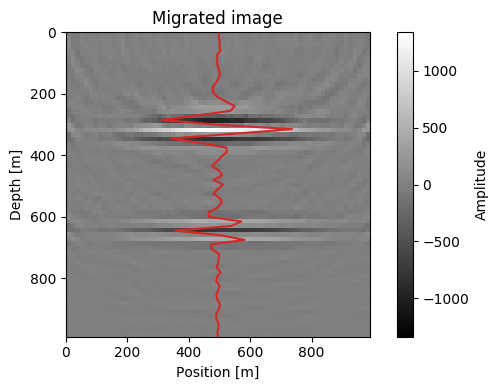

In [13]:
xran = x[end]-x[1]
mod_mig = reshape(m_mig, nz, nx)
vmin, vmax = maximum(abs.(mod_mig))*[-1,1]
fig, ax = plt.subplots(figsize=(6,4))
cax = ax[:imshow](mod_mig, extent=[x[1], x[end], z[end], z[1]],
    vmin=vmin, vmax=vmax, aspect="equal", cmap="gray", interpolation=nothing)
cbar = fig[:colorbar](cax, ax=ax)
cbar[:ax][:set](ylabel="Amplitude");
ax[:plot](xran*mod_mig[:,div(end,2)]./(4vmax) .+ xran./2, z, color="#d62728");
ax[:set](xlim=(x[1], x[end]), ylim=(z[end], z[1]), xlabel="Position [m]", ylabel="Depth [m]",
    title="Migrated image")
fig[:tight_layout]()

### 5. Regularized Least-squares migration

The Kirchhoff forward problem

$$ Lm = d $$

has a Tikhonov-regularized solution of


$$ m_\text{reg} = (L^\dagger L + \Gamma^\dagger \Gamma)^{-1} L^\dagger d $$

where $\Gamma$ is a regularizing matrix.

Here we will try:

* $\Gamma = \mathbf{0}$; no regularization

* $\Gamma = \mu I$; minimum norm solution

* $\Gamma = \mu \Delta$; minimum curvature solution

where $\mu$ is a scaling factor. A common choice for the scaling factor is to use 1% to 10% of the largest eigenvalue of $L^\dagger L$. If calculating this is hard, another possible choice is substituting the largest eigenvalue for $\frac{\|L'L u\|}{\|u\|}$ where $u$ is a random vector. In case a higher percentage can be applied to it, as it is equivalent to an average of all eigenvalues.

In [14]:
import IterativeSolvers: cg
@time m_lsm_0, hist_0 = cg(L'L, m_mig, maxiter=20, log=true);

  9.959116 seconds (4.79 M allocations: 706.414 MiB, 2.32% gc time)


In [15]:
using Arpack
@time λ, ϕ = eigs(L'L; nev=1, maxiter=2); λ = λ[1];

 19.351974 seconds (10.52 M allocations: 1.203 GiB, 3.12% gc time)


In [16]:
import LinearMaps: IdentityMap

Id = IdentityMap(size(L'L, 1))
@time m_lsm_id, hist_id = cg(L'L + 0.01λ*Id, m_mig, maxiter=20, log=true);

  7.345916 seconds (3.32 M allocations: 633.368 MiB, 2.94% gc time)


In [17]:
Δ = KirchMig.LaplacianMap(nz, nx);

In [18]:
@time m_lsm_lap, hist_lap = cg(L'L + 0.01λ*Δ'Δ, m_mig, maxiter=20, log=true);

  8.027170 seconds (4.55 M allocations: 723.483 MiB, 3.40% gc time)


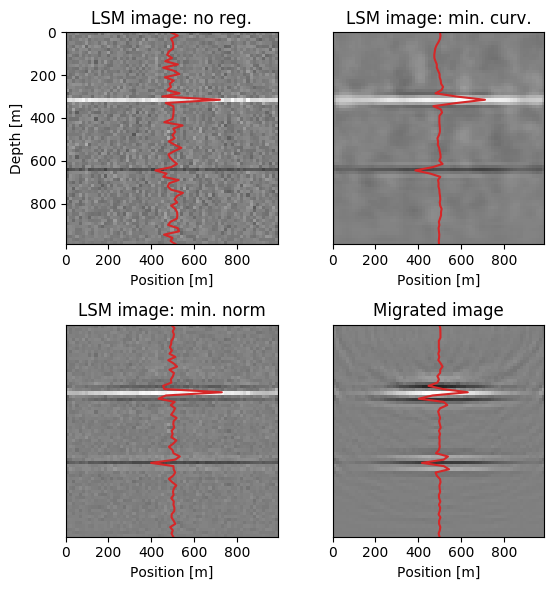

In [19]:
mod_lsm = reshape(m_lsm_0, nz, nx)
mod_lsm_id = reshape(m_lsm_id, nz, nx)
mod_lsm_lap = reshape(m_lsm_lap, nz, nx)

fig, ax = plt.subplots(2, 2, figsize=(6,6))
pclip=1
vmin, vmax = pclip*maximum(abs.(mod_lsm))*[-1,1]
ax[1][:imshow](mod_lsm, extent=[x[1], x[end], z[end], z[1]],
    vmin=vmin, vmax=vmax, aspect="equal", cmap="gray", interpolation=nothing)
ax[1][:set](xlabel="Position [m]", ylabel="Depth [m]", title="LSM image: no reg.")
ax[1][:plot](250mod_lsm[:,50]./vmax .+ 500, z, color="#d62728");

vmin, vmax = pclip*maximum(abs.(mod_lsm_id))*[-1,1]
ax[2][:imshow](mod_lsm_id, extent=[x[1], x[end], z[end], z[1]],
    vmin=vmin, vmax=vmax, aspect="equal", cmap="gray", interpolation=nothing)
ax[2][:set](xlabel="Position [m]",title="LSM image: min. norm", yticks=[])
ax[2][:plot](250mod_lsm_id[:,50]./vmax .+ 500, z, color="#d62728");

vmin, vmax = pclip*maximum(abs.(mod_lsm_lap))*[-1,1]
ax[3][:imshow](mod_lsm_lap, extent=[x[1], x[end], z[end], z[1]],
    vmin=vmin, vmax=vmax, aspect="equal", cmap="gray", interpolation=nothing)
ax[3][:set](xlabel="Position [m]",title="LSM image: min. curv.", yticks=[])
ax[3][:plot](250mod_lsm_lap[:,50]./vmax .+ 500, z, color="#d62728");

vmin, vmax = pclip*maximum(abs.(mod_mig))*[-1,1]
ax[4][:imshow](mod_mig, extent=[x[1], x[end], z[end], z[1]],
    vmin=vmin, vmax=vmax, aspect="equal", cmap="gray", interpolation=nothing)
ax[4][:set](xlabel="Position [m]",title="Migrated image", yticks=[])
ax[4][:plot](250mod_mig[:,50]./vmax .+ 500, z, color="#d62728");
fig[:tight_layout]()

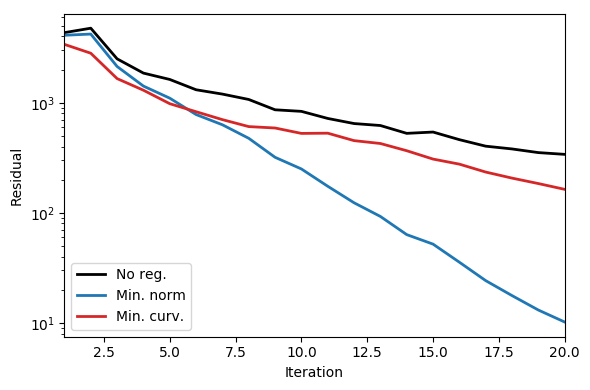

In [20]:
fig, ax = plt.subplots(figsize=(6,4))
iter = length(hist_0.data[:resnorm])
ax[:semilogy](1:iter, hist_0.data[:resnorm], "k", label="No reg.", linewidth=2)

iter = length(hist_id.data[:resnorm])
ax[:semilogy](1:iter, hist_id.data[:resnorm], "#1f77b4", label="Min. norm", linewidth=2)

iter = length(hist_lap.data[:resnorm])
ax[:semilogy](1:iter, hist_lap.data[:resnorm], "#d62728", label="Min. curv.", linewidth=2)

ax[:set](xlabel="Iteration", ylabel="Residual", xlim=(1, iter))
plt.legend(loc=3)
fig[:tight_layout]()